# Iris Segmentation in Pytorch

***In this notebook we are going to implement UNET architechture for Iris Segmentation***

In [3]:
# mount drive with google colab
from google.colab import drive
drive.mount('/content/gdrive')

KeyboardInterrupt: ignored

In [1]:
## Importing the necessary datasets ##

import os

from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torchvision.transforms.functional import resize 
from torch.utils.data import DataLoader , Dataset
from torchvision.utils import make_grid , save_image

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

With all the packages imported its time to get our hands dirty with the project.

It is always better to visualize the dataset to get a taste of what it is.

We are going to utilize PIL and matplotlib for this purpose.

In [2]:
## Visualizing image and mask ##

## Opening the image and mask images ##
img = Image.open('/content/gdrive/MyDrive/final_year_project/CLASSES_400_300_Part1/C1_S1_I1.tiff').convert('RGB')
img_mask = Image.open('/content/gdrive/MyDrive/final_year_project/train/ubiris2_1/ubiris/OperatorA_C1_S1_I1.tiff').convert('L') ## To extract only the content ##

## Converting them into arrays ##
img_arr = np.array(img) / 255.
mask_arr = np.array(img_mask) / 255.

## Plotting the image ##
plt.subplot(1 , 2 , 1)
plt.imshow(img_arr)

## Plotting the mask ##
plt.subplot(1 , 2 , 2)
plt.imshow(mask_arr)

plt.show()

FileNotFoundError: ignored

So we can sense the way we need to repurpose our dataset to feed data to our model, which is the main building block of this project.

In the subsequent cells we are going to implement the dataset for our project and we need to do the following things.

* [ ] Create a dataset class which inherits from the pytorch dataset module.
* [ ] Initialize the constructor for the class which takes the image and mask path.
* [ ] Override the __getitem__method which outputs a set of data and label by taking in an index.
* [ ] Override the __len__ method to determine the length of the dataset.



In [ ]:
## Creating the custom dataset ##

class BacteriaDataset(Dataset):
    
    def __init__(self , img_path , mask_path):
        self.base_path = '/content/gdrive/MyDrive/final_year_project'
        self.img_path = img_path
        self.mask_path = mask_path
        self.img_list = os.listdir(os.path.join(self.base_path , img_path))
        self.mask_list = os.listdir(os.path.join(self.base_path , mask_path))
        self.dataset_len = len(self.img_list)
        
    def __getitem__(self , idx):
        cycle_idx = idx % self.dataset_len
        
        img = Image.open(os.path.join(os.path.join(self.base_path , self.img_path) , self.img_list[cycle_idx])).convert('RGB')
        img_mask = Image.open(os.path.join(os.path.join(self.base_path , self.mask_path) , self.mask_list[cycle_idx])).convert('L') 
        
        aug = transforms.Compose([
            transforms.Resize((64 , 64)),
            transforms.ToTensor()
        ])
        
        img_tensor = aug(img)
        mask_tensor = aug(img_mask)
        
        
        return img_tensor , mask_tensor
    
    def __len__(self):
        return self.dataset_len

In [ ]:
## Instantiating the dataset ##

bacteria_data = BacteriaDataset('CLASSES_400_300_Part1' , 'train_jpg/train_mask')

print('The length of the dataset is :' , len(bacteria_data))

The length of the dataset is : 50


We can see that the code ran without error.

But it is of the best interest to visualize an example for error checking. So lets do that.

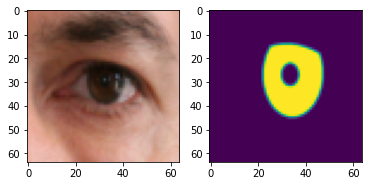

In [ ]:
## Visualizing a data point ##

np.random.seed(47)

rand_idx = int(np.random.randint(0 , len(bacteria_data) , size = 1))

img , mask = bacteria_data[rand_idx]

#img = img.squeeze(0)
#mask = mask.squeeze(0)

## Plotting the image ##
plt.subplot(1 , 2 , 1)
plt.imshow(img.permute(1 , 2 , 0))

## Plotting the mask ##
plt.subplot(1 , 2 , 2)
plt.imshow(np.squeeze(mask.permute(1 , 2, 0)))

plt.show()

Now with the dataset out of the way, it would be really unreasonable to put the entire dataset to the model.

Hence, comes the requirements of a DataLoader. It takes in the dataset as input and spits out batches of data for updation of weight via mini-batches.

In [ ]:
## Instantiating DataLoader ##

bacteria_dl = DataLoader(bacteria_data , batch_size = 16 , shuffle = True)

print('The length of the dataloader is:' , len(bacteria_dl))

The length of the dataloader is: 4


Its always better to visualize a set of the dataset to get better insight.

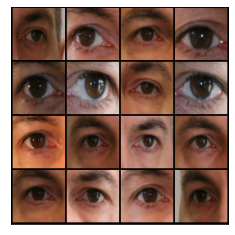

In [ ]:
## Displaying images ##

for img , mask in bacteria_dl:
    fig , ax = plt.subplots(figsize = (4 , 4))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(make_grid(img  , 4).permute(1 , 2 , 0))
    #plt.imshow(make_grid(mask , 4).permute(1 , 2 , 0))
    plt.show()
    break

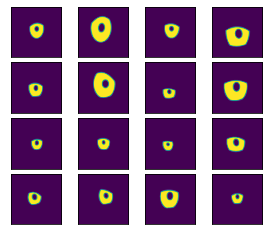

In [ ]:
## Displaying mask ##

for img , mask in bacteria_dl:
    for i in range(len(mask)):
        plt.subplot(4 , 4 , i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(np.squeeze(mask[i].permute(1 , 2 , 0)))
    plt.subplots_adjust(wspace=-0.5, hspace=0.1)
    plt.show()
    break

Now we have created the dataloader.

But, it is not enough! Why not? Well the dataloader utilizes cpu for its working. But that is quite inefficient. We need to push it to GPU. Hence we need to write some code which would do that for us and make the process much more efficient.

In [ ]:
## GPU transfer utility functions ##

def check_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

def transfer_data(data , device):
    if isinstance(data , (list , tuple)):
        return [transfer_data(each_data , device) for each_data in data]
    return data.to(device)

Now we have sorted the utility functions.

Now next what we do is create our custom dataloader which utilizes GPU.

In [ ]:
## GPU Dataloader ##

class GPUDataLoader():
    
    def __init__(self , dl , device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for batch in self.dl:
            yield transfer_data(batch , self.device)
    
    def __len__(self):
        return len(self.dl)

In [ ]:
## Instantiating our dataloader ##

device = check_device()

dl_bacteria = GPUDataLoader(bacteria_dl , device)

Okay! The dataloader is instantiated.

Lets check some test cases such that we can be assured of the requirements

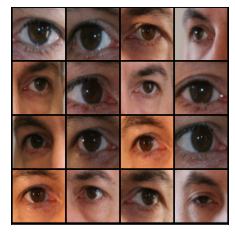

In [ ]:
## Displaying images ##

for img , mask in dl_bacteria:
    fig , ax = plt.subplots(figsize = (4 , 4))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(np.squeeze(make_grid(img.to('cpu')  , 4).permute(1 , 2 , 0)))
    #plt.imshow(make_grid(mask , 4).permute(1 , 2 , 0))
    plt.show()
    break

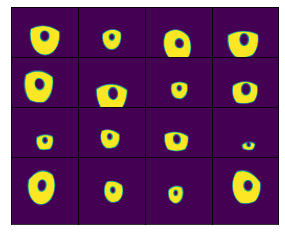

In [ ]:
## Displaying mask ##

for img , mask in dl_bacteria:
    for i in range(len(mask)):
        plt.subplot(4 , 4 , i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(np.squeeze(mask.to('cpu')[i].permute(1 , 2 , 0)))
    plt.subplots_adjust(wspace=-0.5, hspace=-0.25)
    plt.show()
    break

Okay. So our dataloader is working excellently.

So, now we are all set for the final part.

Our main UNET structure.

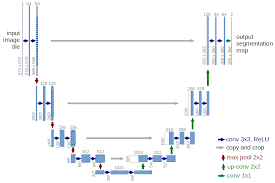

The main architecture of UNET is given above-- from the original paper.

What we are going to do is improvise a bit and carry on.

Our starting dimension is 64,64,3.

So lets model our UNET.

In [ ]:
## Defining Unet Architecture ##

class UnetConv(nn.Module):
    
    def __init__(self , in_dim , out_dim , kernel_size = 3 , padding = 1 , stride = 1):
        
        super().__init__()
        
        self.conv_block = nn.Sequential(nn.Conv2d(in_channels = in_dim , out_channels = out_dim , kernel_size = kernel_size ,
                                       padding = padding , stride = stride , bias = False),
                            nn.BatchNorm2d(num_features = out_dim) ,
                            nn.ReLU(inplace = True),
                            nn.Conv2d(in_channels = out_dim , out_channels = out_dim , kernel_size = kernel_size ,
                                       padding = padding , stride = stride , bias = False),
                            nn.BatchNorm2d(num_features = out_dim) ,
                            nn.ReLU(inplace = True))
        
    def forward(self , inp):
        return self.conv_block(inp)

class BacteriaUNET(nn.Module):
    
    def __init__(self , in_dim = 3 , out_dim = 1 , filters = [64 , 128 , 256 , 512]):
        super().__init__()
        self.filters = filters
        self.out_dim = out_dim
        self.max_pool = nn.MaxPool2d(kernel_size = 2 , stride = 2)
        
        self.down_block = nn.ModuleList([])
        self.up_block = nn.ModuleList([])
        
        for each_filter in self.filters:
            self.down_block.append(UnetConv(in_dim = in_dim , out_dim = each_filter))
            in_dim = each_filter
            
        for each_filter in reversed(self.filters):
            self.up_block.append(nn.ConvTranspose2d(in_channels = each_filter * 2 , out_channels = each_filter , 
                                                    kernel_size = 2 , stride= 2))
            self.up_block.append(UnetConv(in_dim = each_filter * 2 , out_dim = each_filter))
            
        
        self.bridge_block = UnetConv(in_dim = self.filters[-1] , 
                                      out_dim = self.filters[-1] * 2)
        
        self.final_layer = nn.Conv2d(in_channels = self.filters[0] , out_channels = self.out_dim,
                                     kernel_size = 1)
        
        
    def forward(self , x):
        
        down_conv_out = []
        
        for layer in self.down_block:
            x = layer(x) 
            down_conv_out.append(x)
            x = self.max_pool(x)
            
        x = self.bridge_block(x)
        
        down_conv_out = down_conv_out[::-1]
            
        for layer_num in range(0 , len(self.up_block) , 2):
            
            x = self.up_block[layer_num](x)
            skip_conn = down_conv_out[layer_num // 2]
            
            if x.shape != skip_conn.shape:
                
                x = resize(x , size = skip_conn.shape[2:])
                
            
            x = torch.cat((x , skip_conn) , dim = 1)
            
            x = self.up_block[layer_num + 1](x)
            
        x = self.final_layer(x)
        
        return x

In [ ]:
## Instantiating our model ##

model = BacteriaUNET()

model = model.to(device)

NameError: ignored


Now our model is done and dusted.

Lets initialize our loss function and optimizer.

In [ ]:
## Initializing loss function and optimizer ##

loss_fn = nn.BCEWithLogitsLoss()

optim = torch.optim.Adam(params = model.parameters() , lr = 3e-4)

We are going to now move on to the training loop.

Epoch : 1 / 100 --> Loss : 0.599
Epoch : 2 / 100 --> Loss : 0.498
Epoch : 3 / 100 --> Loss : 0.497
Epoch : 4 / 100 --> Loss : 0.399


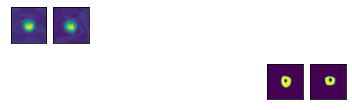

Epoch : 5 / 100 --> Loss : 0.398
Epoch : 6 / 100 --> Loss : 0.395
Epoch : 7 / 100 --> Loss : 0.334
Epoch : 8 / 100 --> Loss : 0.346
Epoch : 9 / 100 --> Loss : 0.302


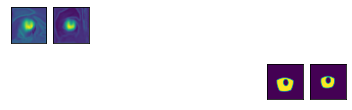

Epoch : 10 / 100 --> Loss : 0.376
Epoch : 11 / 100 --> Loss : 0.302
Epoch : 12 / 100 --> Loss : 0.290
Epoch : 13 / 100 --> Loss : 0.298
Epoch : 14 / 100 --> Loss : 0.287


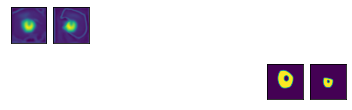

Epoch : 15 / 100 --> Loss : 0.282
Epoch : 16 / 100 --> Loss : 0.281
Epoch : 17 / 100 --> Loss : 0.265
Epoch : 18 / 100 --> Loss : 0.259
Epoch : 19 / 100 --> Loss : 0.250


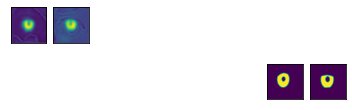

Epoch : 20 / 100 --> Loss : 0.245
Epoch : 21 / 100 --> Loss : 0.256
Epoch : 22 / 100 --> Loss : 0.222
Epoch : 23 / 100 --> Loss : 0.220
Epoch : 24 / 100 --> Loss : 0.241


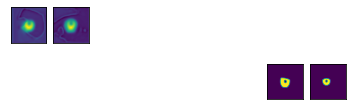

Epoch : 25 / 100 --> Loss : 0.216
Epoch : 26 / 100 --> Loss : 0.214
Epoch : 27 / 100 --> Loss : 0.269
Epoch : 28 / 100 --> Loss : 0.235
Epoch : 29 / 100 --> Loss : 0.200


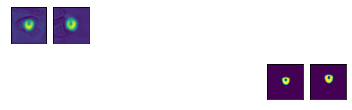

Epoch : 30 / 100 --> Loss : 0.199
Epoch : 31 / 100 --> Loss : 0.193
Epoch : 32 / 100 --> Loss : 0.290
Epoch : 33 / 100 --> Loss : 0.198
Epoch : 34 / 100 --> Loss : 0.193


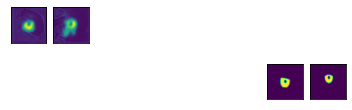

Epoch : 35 / 100 --> Loss : 0.184
Epoch : 36 / 100 --> Loss : 0.210
Epoch : 37 / 100 --> Loss : 0.190
Epoch : 38 / 100 --> Loss : 0.267
Epoch : 39 / 100 --> Loss : 0.183


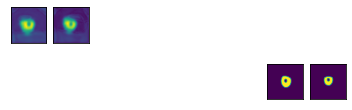

Epoch : 40 / 100 --> Loss : 0.182
Epoch : 41 / 100 --> Loss : 0.189
Epoch : 42 / 100 --> Loss : 0.171
Epoch : 43 / 100 --> Loss : 0.166
Epoch : 44 / 100 --> Loss : 0.171


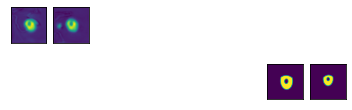

Epoch : 45 / 100 --> Loss : 0.164
Epoch : 46 / 100 --> Loss : 0.154
Epoch : 47 / 100 --> Loss : 0.172
Epoch : 48 / 100 --> Loss : 0.175
Epoch : 49 / 100 --> Loss : 0.143


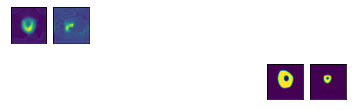

Epoch : 50 / 100 --> Loss : 0.195
Epoch : 51 / 100 --> Loss : 0.148
Epoch : 52 / 100 --> Loss : 0.168
Epoch : 53 / 100 --> Loss : 0.194
Epoch : 54 / 100 --> Loss : 0.160


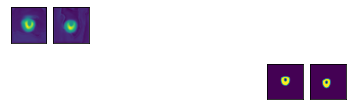

Epoch : 55 / 100 --> Loss : 0.139
Epoch : 56 / 100 --> Loss : 0.169
Epoch : 57 / 100 --> Loss : 0.190
Epoch : 58 / 100 --> Loss : 0.148
Epoch : 59 / 100 --> Loss : 0.142


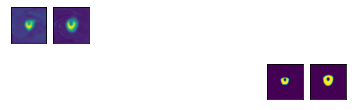

Epoch : 60 / 100 --> Loss : 0.115
Epoch : 61 / 100 --> Loss : 0.235
Epoch : 62 / 100 --> Loss : 0.136
Epoch : 63 / 100 --> Loss : 0.132
Epoch : 64 / 100 --> Loss : 0.112


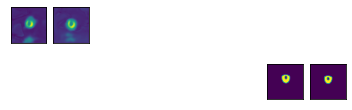

Epoch : 65 / 100 --> Loss : 0.122
Epoch : 66 / 100 --> Loss : 0.114
Epoch : 67 / 100 --> Loss : 0.105
Epoch : 68 / 100 --> Loss : 0.138
Epoch : 69 / 100 --> Loss : 0.132


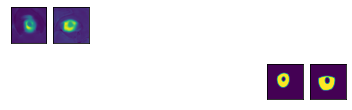

Epoch : 70 / 100 --> Loss : 0.205
Epoch : 71 / 100 --> Loss : 0.109
Epoch : 72 / 100 --> Loss : 0.109
Epoch : 73 / 100 --> Loss : 0.130
Epoch : 74 / 100 --> Loss : 0.177


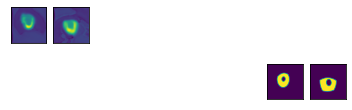

Epoch : 75 / 100 --> Loss : 0.178
Epoch : 76 / 100 --> Loss : 0.127
Epoch : 77 / 100 --> Loss : 0.122
Epoch : 78 / 100 --> Loss : 0.125
Epoch : 79 / 100 --> Loss : 0.149


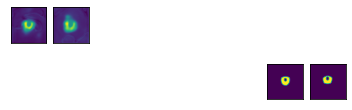

Epoch : 80 / 100 --> Loss : 0.123
Epoch : 81 / 100 --> Loss : 0.104
Epoch : 82 / 100 --> Loss : 0.117
Epoch : 83 / 100 --> Loss : 0.126
Epoch : 84 / 100 --> Loss : 0.102


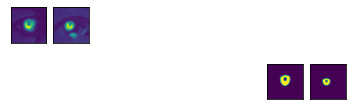

Epoch : 85 / 100 --> Loss : 0.088
Epoch : 86 / 100 --> Loss : 0.087
Epoch : 87 / 100 --> Loss : 0.156
Epoch : 88 / 100 --> Loss : 0.099
Epoch : 89 / 100 --> Loss : 0.105


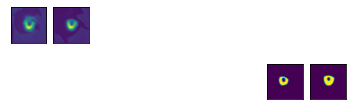

Epoch : 90 / 100 --> Loss : 0.111
Epoch : 91 / 100 --> Loss : 0.077
Epoch : 92 / 100 --> Loss : 0.108
Epoch : 93 / 100 --> Loss : 0.084
Epoch : 94 / 100 --> Loss : 0.087


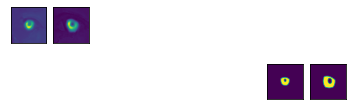

Epoch : 95 / 100 --> Loss : 0.079
Epoch : 96 / 100 --> Loss : 0.122
Epoch : 97 / 100 --> Loss : 0.080
Epoch : 98 / 100 --> Loss : 0.118
Epoch : 99 / 100 --> Loss : 0.120


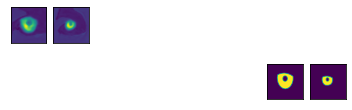

Epoch : 100 / 100 --> Loss : 0.089


In [ ]:
## Training loop ##

num_epochs = 100

for epoch in range(num_epochs):
    
    for img , mask in dl_bacteria:
        
        model.train()
        
        pred = model(img)
        
        loss = loss_fn(pred , mask)
        
        optim.zero_grad()
        
        loss.backward()
        
        optim.step()
    
    model.eval()
    
    if (epoch + 1) % 5 == 0:
        for i in range(len(pred)):
            plt.subplot(4 , 8 , i+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(np.squeeze(pred[i].detach().to('cpu').permute(1 , 2 , 0)))
            plt.subplot(4 , 8 , i+15)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(np.squeeze(mask[i].to('cpu').permute(1 , 2 , 0)))
        
        plt.show()
    
    print('Epoch : {} / {} --> Loss : {:.3f}'.format(epoch + 1 , num_epochs , loss.item()))